In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_47683/3355231087.py:5: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [4]:
hex_cluster = gpd.read_file('../data/processed/hex_clusters.geojson')

In [10]:
hex_cluster.groupby('cluster').agg(['mean','median','std','count']).to_csv('../data/processed/cluster_stats.csv')

In [11]:
hex_cluster.groupby('cluster').agg('mean','median','std').to_csv('../data/processed/cluster_stats_mean.csv')

In [2]:
hex_socio = gpd.read_file('../data/processed/hex_sociodemographic.geojson')
hex_eco = gpd.read_file('../data/processed/hex_economic.geojson')
hex_infra = gpd.read_file('../data/processed/hex_infraestructura.geojson')
hex_env = gpd.read_file('../data/processed/hex_environmental.geojson')
hex_con = gpd.read_file('../data/processed/hex_connectivity.geojson')
hex_us = gpd.read_file('../data/processed/hex_urban_structure.geojson')
hex_prox = gpd.read_file('../data/processed/hex_proximity.geojson')

## Data treatment

In [3]:
hex_gdf = hex_eco[['hex_id_9','geometry']].copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 2)


,hex_id_9,geometry
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2..."
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2..."


### Sociodemographic

In [4]:
hex_socio = hex_socio[['hex_id_9','nse_idx','delitos_count',
                       'del_hab_100','graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_im']]
socio_cols = ['nse_idx','delitos_count',
                       'del_hab_100','graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_im']
hex_socio = hex_socio.fillna(0)
hex_socio_std = hex_socio.copy()
hex_socio_std[socio_cols] = StandardScaler().fit_transform(np.array(hex_socio[socio_cols]))
print(hex_socio_std.shape)
hex_socio_std.head(2)

(1214, 11)


,hex_id_9,nse_idx,delitos_count,del_hab_100,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_im
0,89498c96e0bffff,-0.401887,0.894107,-0.110565,0.443315,-0.308309,-0.512859,-0.338607,0.627745,0.147345,0.255085
1,89498c9608bffff,3.149646,-1.055395,0.379203,-2.496399,-1.318629,-2.068738,4.174164,-2.711336,-2.025362,0.274276


In [5]:
pca = PCA(n_components=3)

x = hex_socio_std.loc[:, socio_cols].values

principalComponents = pca.fit_transform(x)

In [6]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.47086412 0.1765057  0.11062375] Explained variance: 0.7579935679287149


In [7]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2','pc_3'])

hex_socio_pca = hex_socio[['hex_id_9']]
hex_socio_pca.loc[:,'socio_pc_1'] = principalDf['pc_1'].copy()
hex_socio_pca.loc[:,'socio_pc_2'] = principalDf['pc_2'].copy()
hex_socio_pca.loc[:,'socio_pc_3'] = principalDf['pc_3'].copy()

/tmp/ipykernel_50183/4260663316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_socio_pca.loc[:,'socio_pc_1'] = principalDf['pc_1'].copy()
/tmp/ipykernel_50183/4260663316.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_socio_pca.loc[:,'socio_pc_2'] = principalDf['pc_2'].copy()
/tmp/ipykernel_50183/4260663316.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

### Economic

In [8]:
hex_eco = hex_eco[['hex_id_9','dist_tianguis','dist_mercado',
                  'denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11']]
eco_cols = ['dist_tianguis','dist_mercado',
                  'denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11']
hex_eco = hex_eco.fillna(0)
hex_eco_std = hex_eco.copy()
hex_eco_std[eco_cols] = StandardScaler().fit_transform(np.array(hex_eco[eco_cols]))
print(hex_eco_std.shape)
hex_eco_std.head(2)

(1214, 7)


,hex_id_9,dist_tianguis,dist_mercado,denue_count,denue_jobs,denue_jobs_>_11,pct_jobs_>_11
0,89498c9616bffff,0.469064,0.548569,-0.558454,0.110000,0.436736,1.260905
1,89498c96e0bffff,0.184695,-0.189413,2.616098,3.199566,3.093476,0.736937


In [9]:
pca = PCA(n_components=2)

x = hex_eco_std.loc[:, eco_cols].values

principalComponents = pca.fit_transform(x)

In [10]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.4947014  0.33767473] Explained variance: 0.8323761297504153


In [11]:
hex_eco_pca = hex_eco[['hex_id_9']]
hex_eco_pca.loc[:,'eco_pc_1'] = principalComponents[:,0]
hex_eco_pca.loc[:,'eco_pc_2'] = principalComponents[:,1]

/tmp/ipykernel_50183/809235207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_eco_pca.loc[:,'eco_pc_1'] = principalComponents[:,0]
/tmp/ipykernel_50183/809235207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_eco_pca.loc[:,'eco_pc_2'] = principalComponents[:,1]


### Infraestructure

In [12]:
hex_infra = hex_infra[['hex_id_9','pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']]
infra_cols = ['pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']
hex_infra = hex_infra.fillna(0)
hex_infra_std = hex_infra.copy()
hex_infra_std[infra_cols] = StandardScaler().fit_transform(np.array(hex_infra[infra_cols]))
print(hex_infra_std.shape)
hex_infra_std.head(2)

(1214, 6)


,hex_id_9,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
0,89498c95c87ffff,-1.403832,0.001843,-1.850503,-0.227174,-0.324556
1,89498c94e8bffff,0.423679,-0.394078,0.876390,0.432385,-0.324556


In [13]:
pca = PCA(n_components=2)

x = hex_infra_std.loc[:, infra_cols].values

principalComponents = pca.fit_transform(x)

In [14]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.56979562 0.19951191] Explained variance: 0.769307526179902


In [15]:
hex_infra_pca = hex_infra[['hex_id_9']]
hex_infra_pca.loc[:,'infra_pc_1'] = principalComponents[:,0].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/489347352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_infra_pca.loc[:,'infra_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/489347352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,1].copy()


### Environment

In [16]:
hex_env = hex_env[['hex_id_9','wgt_ndvi','area_m2','area_pob','dist_ep']]
env_cols = ['wgt_ndvi','area_m2','area_pob','dist_ep']
hex_env = hex_env.fillna(0)
hex_env_std = hex_env.copy()
hex_env_std[env_cols] = StandardScaler().fit_transform(np.array(hex_env[env_cols]))
print(hex_env_std.shape)
hex_env_std.head(2)

(1214, 5)


,hex_id_9,wgt_ndvi,area_m2,area_pob,dist_ep
0,89498c9616bffff,-1.244980,-0.453956,-0.081136,-0.215064
1,89498c97303ffff,1.169273,3.749943,-0.051318,0.236633


In [17]:
pca = PCA(n_components=2)

x = hex_env_std.loc[:, env_cols].values

principalComponents = pca.fit_transform(x)

In [18]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.41319155 0.25298643] Explained variance: 0.666177986771178


In [19]:
hex_env_pca = hex_env[['hex_id_9']]
hex_env_pca.loc[:,'env_pc_1'] = principalComponents[:,0].copy()
hex_env_pca.loc[:,'env_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/1401993089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_env_pca.loc[:,'env_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/1401993089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_env_pca.loc[:,'env_pc_2'] = principalComponents[:,1].copy()


### Connectivity

In [20]:
hex_con = hex_con[['hex_id_9','dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']]
conn_cols = ['dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']
hex_con = hex_con.fillna(0)
hex_con_std = hex_con.copy()
hex_con_std[conn_cols] = StandardScaler().fit_transform(np.array(hex_con[conn_cols]))
print(hex_con_std.shape)
hex_con_std.head(2)

(1214, 5)


,hex_id_9,dist_ciclo,ruta_count,dist_tp,dist_tpm
0,89498c95c87ffff,0.177925,-0.928833,0.285080,0.160424
1,89498c94e8bffff,-0.576193,0.581687,-0.313804,-0.595755


In [21]:
pca = PCA(n_components=2)

x = hex_con_std.loc[:, conn_cols].values

principalComponents = pca.fit_transform(x)

In [22]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.52776501 0.28335031] Explained variance: 0.8111153169189178


In [23]:
hex_con_pca = hex_con[['hex_id_9']]
hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/986357026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/986357026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()


### Urban structure

In [24]:
hex_us = hex_us[['hex_id_9','Baldios','Comercio y Servicios',
                'Equipamiento','Espacios Abiertos','Habitacional','Industrial',
                'pct','street_dens','wgt_ss']]
us_cols = ['Baldios','Comercio y Servicios',
                'Equipamiento','Espacios Abiertos','Habitacional','Industrial',
                'pct','street_dens','wgt_ss']
hex_us = hex_us.fillna(0)
hex_us_std = hex_us.copy()
hex_us_std[us_cols] = StandardScaler().fit_transform(np.array(hex_us[us_cols]))
print(hex_us_std.shape)
hex_us_std.head(2)

(1160, 10)


,hex_id_9,Baldios,Comercio y Servicios,Equipamiento,Espacios Abiertos,Habitacional,Industrial,pct,street_dens,wgt_ss
0,89498c96e0bffff,-0.097343,1.134623,-0.362914,-0.416366,-0.319325,-0.160675,-0.596857,-0.091060,0.967271
1,89498c94313ffff,-0.187362,-0.596361,0.881481,-0.416366,0.589652,-0.316066,-0.049981,0.262394,0.783901


In [25]:
pca = PCA(n_components=4)

x = hex_us_std.loc[:, us_cols].values

principalComponents = pca.fit_transform(x)

In [26]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.30260212 0.20169397 0.12300117 0.11554228] Explained variance: 0.7428395496782503


In [27]:
hex_us_pca = hex_us[['hex_id_9']]
hex_us_pca.loc[:,'us_pc_1'] = principalComponents[:,0].copy()
hex_us_pca.loc[:,'us_pc_2'] = principalComponents[:,1].copy()
hex_us_pca.loc[:,'us_pc_3'] = principalComponents[:,2].copy()
hex_us_pca.loc[:,'us_pc_4'] = principalComponents[:,3].copy()

/tmp/ipykernel_50183/2873954002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_us_pca.loc[:,'us_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/2873954002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_us_pca.loc[:,'us_pc_2'] = principalComponents[:,1].copy()
/tmp/ipykernel_50183/2873954002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

### Proximity

In [28]:
hex_prox = hex_prox[['hex_id_9','15_min_analysis',
                    'Entretenimiento','Comercio',
                    'Servicios comunitarios','Escuelas']]
prox_cols = ['15_min_analysis',
                    'Entretenimiento','Comercio',
                    'Servicios comunitarios','Escuelas']
hex_prox = hex_prox.fillna(0)
hex_prox_std = hex_prox.copy()
hex_prox_std[prox_cols] = StandardScaler().fit_transform(np.array(hex_prox[prox_cols]))
print(hex_prox.shape)
hex_prox.head(2)

(1214, 6)


,hex_id_9,15_min_analysis,Entretenimiento,Comercio,Servicios comunitarios,Escuelas
0,89498c95c27ffff,0.0,0.0,0.0,0.0,0.0
1,89498c9426bffff,0.0,0.0,0.0,0.0,0.0


In [29]:
pca = PCA(n_components=2)

x = hex_prox_std.loc[:, prox_cols].values

principalComponents = pca.fit_transform(x)

In [30]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.81602574 0.08076748] Explained variance: 0.8967932256976998


In [31]:
hex_prox_pca = hex_prox[['hex_id_9']]
hex_prox_pca.loc[:,'prox_pc_1'] = principalComponents[:,0].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/2099321363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_prox_pca.loc[:,'prox_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/2099321363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,1].copy()


## Merge data

In [32]:
hex_mrg = hex_gdf.merge(hex_socio, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_eco, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_infra, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_env, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_con, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_us, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_prox, on='hex_id_9', how='left')

In [33]:
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 2)


,hex_id_9,geometry
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2..."
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2..."


In [34]:
hex_pca = hex_gdf.merge(hex_socio_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_eco_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_infra_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_env_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_con_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_us_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_prox_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.fillna(0)

## k-means

In [35]:
data = hex_pca.drop(columns=['hex_id_9','geometry']).to_numpy()

In [36]:
hex_pca.isna().sum()

hex_id_9      0
geometry      0
socio_pc_1    0
socio_pc_2    0
socio_pc_3    0
eco_pc_1      0
eco_pc_2      0
infra_pc_1    0
infra_pc_2    0
env_pc_1      0
env_pc_2      0
conn_pc_1     0
conn_pc_2     0
us_pc_1       0
us_pc_2       0
us_pc_3       0
us_pc_4       0
prox_pc_1     0
prox_pc_2     0
dtype: int64

{2: 0.5090998536615083, 3: 0.4800635661869351, 4: 0.23835348140091825, 5: 0.2523839607001172, 6: 0.26175888558749744, 7: 0.25997917243195884, 8: 0.24792991056777705, 9: 0.16579108820352148, 10: 0.1656255988260543, 11: 0.17129758997682587, 12: 0.17638161146035944, 13: 0.1753705078260333, 14: 0.18062595280466548, 15: 0.1642356698967293, 16: 0.16841384435582202, 17: 0.17175931017870627, 18: 0.17402956516796114, 19: 0.1702154308808958, 20: 0.15999752745412746, 21: 0.15530149836165424, 22: 0.16573505365081734, 23: 0.16451248052864434, 24: 0.16046053322274437, 25: 0.16095954076938657, 26: 0.15932174157000914, 27: 0.15438428746726565, 28: 0.15245419862443504, 29: 0.1538564534829984}


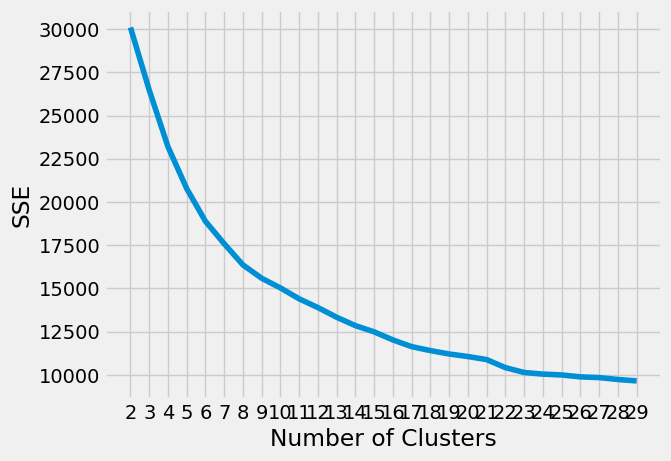

In [37]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [38]:
kmeans = KMeans(
    init="random",
    n_clusters=15,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([ 1, 13,  1, ..., 14,  4,  7], dtype=int32)

<AxesSubplot: >

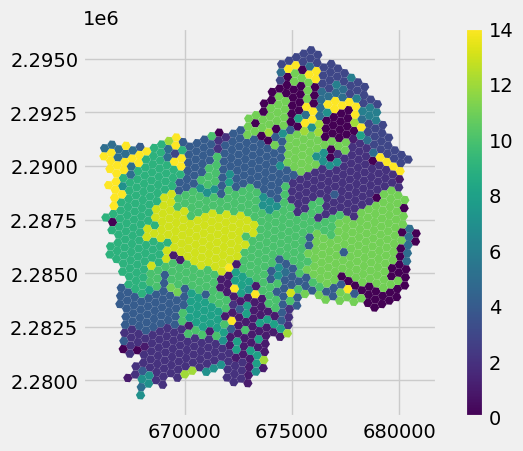

In [64]:
hex_mrg['cluster'] = clusters
hex_mrg.plot('cluster', legend=True)

In [40]:
hex_mrg.groupby('cluster').mean()

,nse_idx,delitos_count,del_hab_100,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_im,...,Habitacional,Industrial,pct,street_dens,wgt_ss,15_min_analysis,Entretenimiento,Comercio,Servicios comunitarios,Escuelas
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.146350,80.371795,8.293380,10.654639,103.701010,0.577560,0.290855,0.595584,0.113561,121.840772,...,0.512445,0.011969,0.636191,0.867955,0.700935,11.003192,2.212965,4.958646,1.710022,2.121559
1,0.238789,82.518519,299.100888,8.594731,31.637093,0.439372,0.206063,0.494170,0.133100,122.250993,...,0.143792,0.307682,0.560345,0.521709,0.872159,10.327022,1.968382,4.771135,1.672693,1.914813
2,0.541643,146.090361,7.429350,9.722298,174.396763,0.496500,0.271932,0.575063,0.153006,121.300569,...,0.728346,0.011630,0.451306,1.019090,0.893047,12.315664,2.349465,4.999646,2.397049,2.569505
3,0.000000,0.312500,31.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003153,0.000000,0.987758,0.150434,0.492339,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.686380,165.536585,15.695240,12.772138,99.915159,0.718610,0.182917,0.590113,0.226970,123.606532,...,0.680920,0.008894,0.463585,0.817487,0.837748,12.950869,2.648022,4.998631,2.811944,2.492272
5,0.802773,4.838710,382.400191,1.720878,4.332525,0.102765,0.302334,0.097666,0.019355,118.928246,...,0.061588,0.000029,0.927871,0.494312,0.549356,4.640489,1.442770,2.131554,0.449147,0.617018
6,0.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.014119,0.421029,0.000000,0.000000,0.000000,0.000000,0.000000
7,-0.076329,74.903226,34.909034,10.454581,49.308300,0.501892,0.254465,0.537349,0.143670,122.857356,...,0.176201,0.008686,0.744410,0.695474,0.817336,11.286515,2.177735,4.767757,2.164347,2.176676
8,2.960673,77.073171,6953.678862,0.000000,0.063108,0.000000,0.975610,0.000000,0.000000,101.857722,...,0.024994,0.342985,0.487450,0.502021,1.032662,9.375850,1.938340,4.473124,1.579294,1.385093


In [62]:
hex_hm = hex_mrg.drop(columns=['denue_jobs_>_11','area_m2',
                               'denue_jobs','area_pob','denue_count',
                              'del_hab_100','delitos_count','dens_pob_ha','wgt_im',
                              'dist_ciclo','dist_tpm','pct_jobs_>_11'])

<AxesSubplot: ylabel='cluster'>

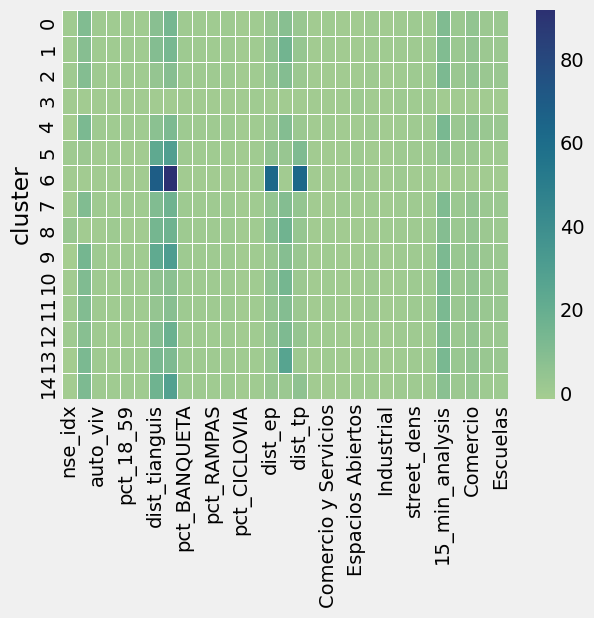

In [63]:
sns.heatmap(hex_hm.groupby('cluster').mean(), 
            annot=False,fmt=".1f", linewidth=.5, cmap="crest")

In [65]:
hex_mrg.to_file('../data/processed/hex_clusters.geojson')